<a href="https://colab.research.google.com/github/avkornaev/Fast_AI_course/blob/main/IRI_defects_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Установка библиотек**

In [27]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

**Импорт библиотек**

In [28]:
from fastai.vision.all import *

**Загрузка данных**

In [59]:
path =  Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training')
path_all = Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset')

In [30]:
path.ls()

(#2) [Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Norm'),Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Bad')]

Скачивание файлов изображений.

In [31]:
files = get_image_files(path)

In [32]:
len(files)

214

In [33]:
files[0],files[2]

(Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Norm/img_thermal_1637761638400.jpg'),
 Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Norm/img_thermal_1637761920622.jpg'))

**Создание датасета**

Используется DataBlock и DataLoader, которые считывает разметку данных с названия папки с помощью функции parent_label.



In [34]:
IRI_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label)

In [35]:
IRI_data = IRI_data.new(item_tfms=Resize(224),batch_tfms=aug_transforms(mult=2))

In [ ]:
# bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))

In [36]:
dls = IRI_data.dataloaders(path)

Просмотр примера изображений

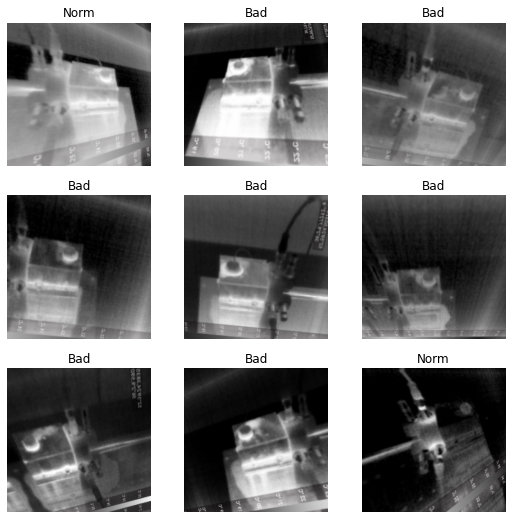

In [37]:
dls.show_batch(max_n=9, nrows=2, unique=True)

**Обучение**

In [38]:
#??cnn_learner

In [39]:
learn = cnn_learner(dls,resnet34,metrics=error_rate,pretrained=True,lr=0.00363)

Целевая функция

In [40]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Метод поиска экстремума

In [41]:
learn.opt_func

<function fastai.optimizer.Adam>

Подбор скорости обучения
Строку ниже можно закоментировать. Для случая трансферного обучения resnet18 рекомендуемая скорость обучения lr
SuggestedLRs(valley=0.0014454397605732083)

для resnet34
SuggestedLRs(valley=0.00363078061491251

In [42]:
# hide
# learn.lr_find()

In [43]:
learn.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,1.116892,1.626496,0.714286,01:01


epoch,train_loss,valid_loss,error_rate,time
0,1.244373,1.071533,0.595238,01:19
1,1.163944,0.892245,0.547619,01:19
2,1.136330,0.898524,0.571429,01:18
3,1.130651,0.984131,0.595238,01:21
4,1.161916,0.873931,0.500000,01:33
5,1.141223,0.888504,0.500000,01:24
6,1.144313,0.807492,0.476190,01:20
7,1.109230,0.784588,0.500000,01:20
8,1.081128,0.809468,0.500000,01:22
9,1.067148,0.671311,0.333333,01:21


**Результаты**

Предсказание для любого конкретного изображения

In [44]:
learn.predict(files[101]),files[101]

(('Bad', TensorBase(0), TensorBase([0.9168, 0.0832])),
 Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Bad/img_thermal_1637833041811.jpg'))

Визуализация предсказаний.

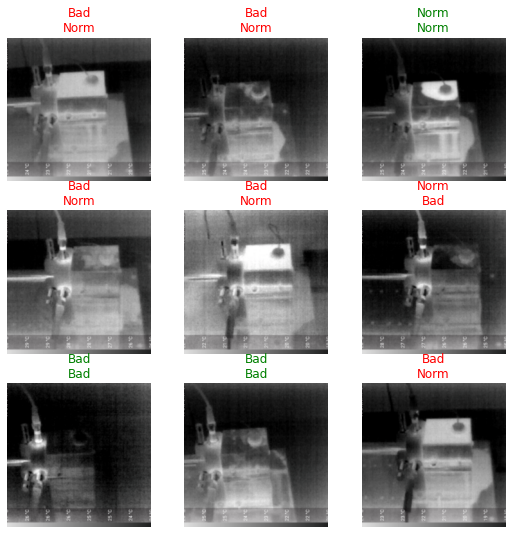

In [45]:
learn.show_results()

Визуализация топа ошибок.

In [ ]:
interp.plot_top_losses(5, nrows=1)

**Оценка точности**

Матрица ошибок

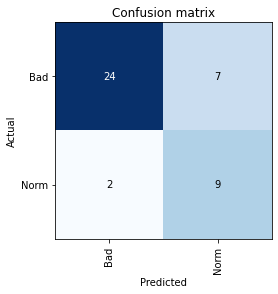

In [46]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [47]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

24 7 2 9


In [48]:
sensitivity = tp/(tp + fn)
sensitivity

0.8181818181818182

Специфичность

In [49]:
specificity = tn/(fp + tn)
specificity

0.7741935483870968

Positive Predictive Value (PPV)

In [50]:
ppv = tp/(tp+fp)
ppv

0.5625

Negative Predictive Value (NPV)

In [51]:
npv = tn/(tn+fn)
npv

0.9230769230769231

Calculating Accuracy

In [52]:
acc = (tp+tn)/(tp+tn+fp+fn)
acc

0.7857142857142857

From the book:
Remember that a model consists of two parts: the architecture and the trained parameters. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the export method.

This method even saves the definition of how to create your DataLoaders. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set DataLoader for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call export, fastai will save a file called "export.pkl":

Сохранение обученной сети

In [54]:
learn.export()

Проверка результатов сохранения

In [55]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

Использование обученной сети для предсказаний на новых данных. 

In [60]:
learn_inf = load_learner(path_all/'export.pkl')

In [61]:
files_test = get_image_files(path_all/'Test')

In [62]:
len(files_test)

10

Предсказание на тестовых изображениях

Одно изображение

In [86]:
learn_inf.predict(files_test[0])

('Norm', TensorBase(1), TensorBase([0.0054, 0.9946]))

Вся папка

In [137]:
def func_accuracy(files_test):
  tp, tn, fp, fn, acc = 0, 0, 0, 0, 0
  feed = [0]*len(files_test)
  pred = [0]*len(files_test)
  gtrue = [0]*len(files_test)
  labels_voc = learn_inf.dls.vocab # labels
  for ind, o in enumerate(files_test):
    feed[ind] = learn_inf.predict(o)
    pred[ind] = labels_voc[feed[ind][-1].argmax()]
    gtrue[ind] =feed[ind][0]
    acc += int(gtrue[ind] == pred[ind])
    #print(gtrue[ind], pred[ind])
  return acc/len(files_test)

In [138]:
func_accuracy(files_test)

1.0

Ссылки:

https://github.com/avkornaev/Fast_AI_course/blob/main/02_production_v3_online.ipynb

https://docs.fast.ai/tutorial.medical_imaging.html

https://docs.fast.ai/data.block.html#DataBlock


